
# UofT DSI-CARTE ML Bootcamp
#### Date
#### Fairness and Equity - Lab 1, Day 4
#### Teaching team: Eldan Cohen, Alex Olson, Nakul Upadhya, Shehnaz Islam
##### Lab author: Nakul Upadhya

As decision-making increasingly relies on artificial intelligence, the issue of fairness and equity in machine learning is rapidly becoming a larger concern. In this lab, we will introduce various metrics that help analyze the biases of our models, as well as techniques that can help mitigate these discrepancies.

The main packages we will be using in this lab is `fairlearn` [1] and `shap` [4].



In [ ]:
!pip install fairlearn
!pip install shap
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup
Before we get to measuring the fairness of a model, we first need to create a model.

For this lab, we will be using the Diabetes 130-Hospitals Dataset [2]. This dataset consists of 10 years worth of clinical care data at 130 US hospitals and integrated delivery networks. Each record represents the admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release [2].

One common task on this dataset is predicting whether or not a patient will be re-admitted to the hospital.


Lets first read all the data in. We will also subset the data and only work with a few columns.

In [ ]:
from fairlearn.datasets import fetch_diabetes_hospital

diabetes_information = fetch_diabetes_hospital()
df = diabetes_information['data']
df = df.dropna()
response = df['readmit_binary']
print(df.columns)
df = df.drop(columns = ['readmitted', 'readmit_binary'])
df.info()

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hosp

Now lets pre-process the data a bit. We will:
* Scale any numerical columns to be between 0 and 1.
* Convert variables with only two values into 0 and 1
* Use one-hot-encoding on the non-binary categorical variables.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

df_list = []

# Select numeric data and scale it

numeric_columns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications', 'number_diagnoses']
numeric_data = df[numeric_columns]
numeric_data[numeric_columns] = MinMaxScaler().fit_transform(numeric_data[numeric_columns])
df_list.append(numeric_data)

# Select binary true/false columns and turn them into zeros and ones
true_false_columns = ['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days','had_outpatient_days']
true_false_data = df[true_false_columns]
true_false_data.replace({'False': 0, 'True': 1}, inplace=True)
df_list.append(true_false_data)

# One hot encoding of the categorical columns
categorical_columns = ['race','gender','age','max_glu_serum','A1Cresult',
                       'insulin','change','diabetesMed']
categorical_data = df[categorical_columns]
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(categorical_data)
end_features = []
for feature, categories in zip(categorical_columns, encoder.categories_):
  end_features = end_features + [f"{feature}_{category}" for category in categories]
encoded_data = pd.DataFrame(encoded_data, columns = end_features)
df_list.append(encoded_data)

# Join all the data back together
X = pd.concat(df_list, axis=1)

Lets also split this into a train and test set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, response, test_size=0.25, random_state=42)
print(f"There are {len(y_train)} training points and {len(y_test)} testing_points")
# # We will need this dataframe later

There are 76324 training points and 25442 testing_points


**Your Turn**

* Choose one of these models:
  - BernoulliNB
  - DecisionTreeClassifier
  - GradientBoostingClassifier
  - KNeighborsClassifier
  - LogisticRegression
  - RandomForestClassifier
  - SVC
* Fit your chosen model on your train set
* Make a prediction with your model on the test set and save it in a variable called `y_pred`
* Report the model accuracy, true positive rate (TPR), and true negative rate (TNR) on your testing set.
  - Accuracy: *YOUR ANSWER HERE*
  - TPR: *YOUR ANSWER HERE*
  - TNR:*YOUR ANSWER HERE*




In [ ]:
## Insert your model imports here

## Metrics import
from sklearn.metrics import confusion_matrix

## Create the model
model = None # Replace `None` with the model of your choice.

## Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Calculate accuracy, TPR, and TNR
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("True Positive Rate (TPR):", tpr)
print("True Negative Rate (TNR):", tnr)
print("Accuracy: ", accuracy)

True Positive Rate (TPR): 0.5028469448457551
True Negative Rate (TNR): 0.6743692870201097
Accuracy:  0.5950396981369389


## Explainability

One way we can use machine learning is to explore potential systemic issues present in the data. To do this we can either use explainable models (ex. linear regression, decision trees, GAMS, etc.), or use post-hoc methods of explanation that work on any model. By examining what features are being heavily used and how they impact the end predictions, we can understand patterns in the underlying system that may not have been apparent.

One such method is SHAP (Shapely Additive Values). SHAP provides feature importance by using methods from game theory to estimate the contribution of each feature towards the final prediction.

There are two types of ML explainability: Local and Global. Local explainability focuses on explaining the reasoning behind individual predictions. In contrast, global explainability attempts to explain general patterns in the model reasoning. For our dataset, a local explanation could look like "We predicted patient 10 would be readmitted since they have high insulin and are 82" while a global explanation would look something like "In general, the model tends to predict readmission when dealing with older patients, or patients with higher insulin levels."

SHAP can provide a sense of both local and global interpretability. We start off by first creating a summary of our dataset (this is to make SHAP run faster) and creating our explainaner object.

In [ ]:
import shap
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
# this helps everything run faster
X_train_summary = shap.kmeans(X_train, 10)

# Create the shap explainer by passing in our model's predict function and
# the summarized training set
ex = shap.KernelExplainer(model.predict, X_train_summary, feature_names = X_train.columns)

# We are also only going to look at 150 points (to make it easier to visualize)
X_test_subset = X_test.sample(150, random_state = 42).reset_index(drop=True)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


#### Local Explainability

Let's first look into the local explainability provided by SHAP by examining what contributes to the predictions of the first datapoint in our testing subset.

In [ ]:
shap.initjs()
first_datapoint = X_test_subset.iloc[0]
print(first_datapoint)
single_point_shap_values = ex.shap_values(first_datapoint)
shap.force_plot(ex.expected_value, single_point_shap_values, X_test_subset.iloc[0])

time_in_hospital           0.230769
num_lab_procedures         0.183206
num_procedures             0.166667
num_medications            0.312500
number_diagnoses           0.533333
medicare                   0.000000
medicaid                   0.000000
had_emergency              0.000000
had_inpatient_days         1.000000
had_outpatient_days        1.000000
race_AfricanAmerican       0.000000
race_Asian                 0.000000
race_Caucasian             1.000000
race_Hispanic              0.000000
race_Other                 0.000000
race_Unknown               0.000000
gender_Female              0.000000
gender_Male                1.000000
gender_Unknown/Invalid     0.000000
age_30 years or younger    0.000000
age_30-60 years            0.000000
age_Over 60 years          1.000000
max_glu_serum_>200         0.000000
max_glu_serum_>300         0.000000
max_glu_serum_None         0.000000
max_glu_serum_Norm         1.000000
A1Cresult_>7               0.000000
A1Cresult_>8               0

In the plot above, feature values that increased the chance of the model predicting a readmission are in red and have arrows that point to the right (they provide a positive force) and feature values that detract from the probability of readmission are in blue and point to the left. The larger the arrow, the larger the contribution.

**Your Turn**

* What features seem to have the most negative impact to the end prediction of the data point you chose? What about the one with the most positive impact? *YOUR ANSWER HERE*
* Choose a different data point and see if you see any similarities in the features used and their impact towards the end prediction. *YOUR ANSWER HERE*


#### Global Explanability
We can get a sense of global interpretability from SHAP by examining trends in the SHAP values across the variable values. To do this, we can generate a summary plot of the calculated values.

  0%|          | 0/150 [00:00<?, ?it/s]

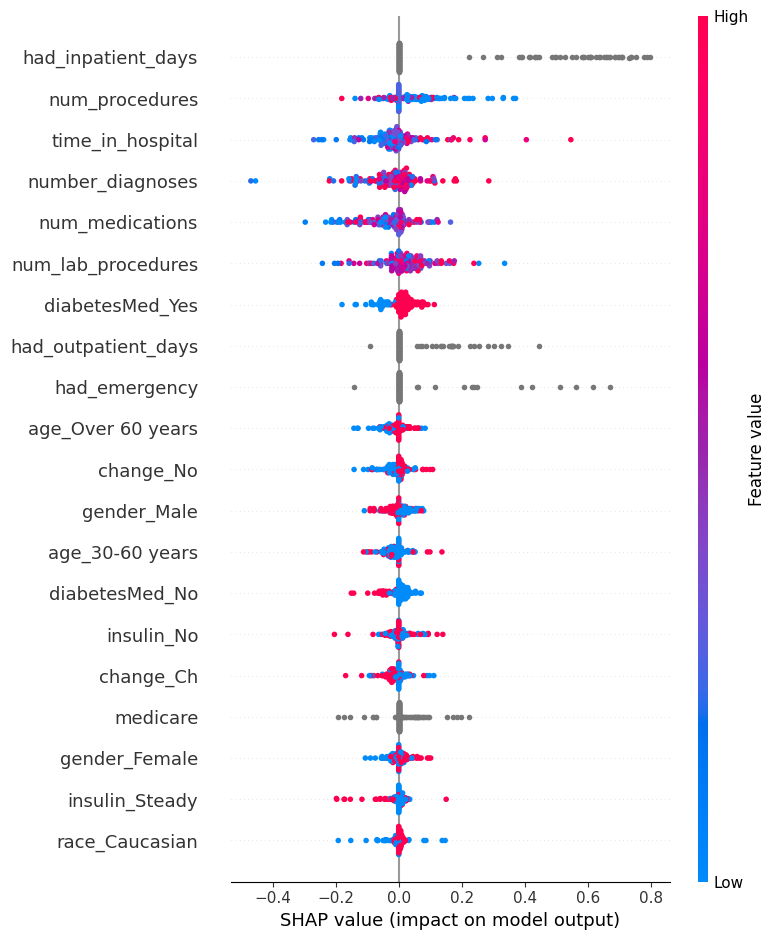

In [ ]:
shap.initjs()
shap_values = ex.shap_values(X_test_subset)
shap.summary_plot(shap_values, X_test_subset)

The color of the point reflects the value of a given feature in a given data point. For example, a red point in `diabetesMed_Yes` means that the feature took a value of 1 (true) and a blue point means a value of 0 (false). The X-axis of this plot represents SHAP contribution (the estimated impact on the end model prediction). By examining the distribution of the feature values across the x-axis, we can find what features may

**Your Turn**

* What features seem important to your model? *YOUR ANSWER HERE*
* In general what impact do they have on the end predictions? *YOUR ANSWER HERE*
* Are there any pattern that make sense to you? *YOUR ANSWER HERE*
* Are there any patterns that seem concerning from an equity perspective? *YOUR ANSWER HERE*

#### Notes about SHAP
SHAP is an incredibly powerful tool to understand what your model may be doing, *however it is only an estimate*. The SHAP value calculations only examine your model's behavior and do not dive into the internals of the model, therefore these values should not be taken at face value. Additionally, as you may have noticed in the plots above, SHAP values do not reflect interacting effects between features, something that most models do in fact use. This extends to other post-hoc interpretability methods as well.

As such, it is highly encouraged to use innately interpretable models whenever possible. For a more rigourous justification, please read Cynthia Rudin's paper on the subject [3].  read after

Additionally, quoting the SHAP documentation [4]:


> Predictive machine learning models like XGBoost become even more powerful when paired with interpretability tools like SHAP. These tools identify the most informative relationships between the input features and the predicted outcome, which is useful for explaining what the model is doing, getting stakeholder buy-in, and diagnosing potential problems. It is tempting to take this analysis one step further and assume that interpretation tools can also identify what features decision makers should manipulate if they want to change outcomes in the future. However, in [this article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html), we discuss how using predictive models to guide this kind of policy choice can often be misleading.

> *Eleanor Dillon, Jacob LaRiviere, Scott Lundberg, Jonathan Roth, and Vasilis Syrgkanis from Microsoft.*









## Fairness
Now that we have understood a bit of what are model is looking at and in general how it handles the features, lets examine how fair and equitable our models performance is. Ideally, a fair model should perform identically across different sensitive identities.



#### Measurement
The first step in ML fairness is to measure how fair the model is. For this, we will introduce two metrics.

The first measure is *Demographic Parity*, or more accurately, the distance from demographic parity. Demographic parity is achieved when the probability of a certain prediction is not dependent on a point being in a sensitive group. This metric takes a range between 0 and 1 where 0 means we have achieved perfect demographic parity with respect to that feature.

In general, a parity of under 20% is acceptable in many countries like the United States [1] to avoid legal problems, **however this should not be the goal as "legally acceptable" is not equal to "fair"**, especially in a high-stakes application such as healthcare (like the dataset we are working with). Read more about the 4/5ths fallacy in the [fairlearn documentation](https://fairlearn.org/v0.8/user_guide/assessment/common_fairness_metrics.html#the-four-fifths-rule-often-misapplied) [1] after the lab.

**Your Turn**
* For this problem in particular, what do you think an acceptable parity difference would be? *YOUR ANSWER HERE*
* Run the cell below that evaluates the difference between asian individuals and non-asian individuals. Is this model fair with regards to this feature? *YOUR ANSWER HERE*
* Test your own sensitive feature by changing `feature_under_examination`.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *YOUR ANSWER HERE*

Tip: Get all features in our data used by running `X_test_df.columns`.

In [ ]:
from fairlearn.metrics import demographic_parity_difference
feature_under_examination = 'race_Asian'
parity_difference = demographic_parity_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
parity_difference = np.round(parity_difference * 100, 3)
print(f"The demographic parity difference for {feature_under_examination} is {parity_difference}%")

The demographic parity difference for race_Asian is 17.299%


The next metric is Equalized Odds. If equalized odds are achieved, that means that the difference in true positive rates and true negative rates across classes is the same. Often times, we measure the maximum difference between these metrics across the classes. For example, if the TPR and TNR for men were 75% and 65% and the rates for women were 73% and 52%, we would report back 13%.

Similar to demographic parity, we want this to be as low as possible. Additionally, this metric is also subject to the 4/5ths fallacy as well.

**Your Turn**
* Between demographic parity and equalized odds, which is a harder criteria to achieve and why? *YOUR ANSWER HERE*
* For this problem in particular, what do you think an acceptable equalized odds difference would be? *YOUR ANSWER HERE*
* Run the cell below that evaluates the difference between asian individuals and non-asian individuals. Is this model fair with regards to this feature? *YOUR ANSWER HERE*
* Test your own sensitive feature by changing `feature_under_examination`.Try a few features to see if you can find one that exceeds the margin you decided. Were you able to find one? *YOUR ANSWER HERE*



In [ ]:
from fairlearn.metrics import equalized_odds_difference
feature_under_examination = 'race_Asian'
eo_difference = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[feature_under_examination])
eo_difference = np.round(eo_difference * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_difference}%")

The Equalized Odds difference for race_Asian is 17.158%


The examples above only focus on identifying fairness across a single group, but most people do not have a single identity and we also need to examine the impacts of intersectionality (ex. white man vs. black man or woman with medicare vs. woman without medicare).

**Your Turn**

* Run the cell below that evaluates the equalized odds difference for Asian Women. Is this model fair with regards to the intersection of these features? *YOUR ANSWER HERE*
* Test your own sensitive features by changing `feature_1` and `feature_2`.Try a few features to see if you can find an intersection that exceeds the margin you decided. Were you able to find one? Make sure the meaning of the features are different (don't use two race features or two gender features).  *YOUR ANSWER HERE*

In [ ]:
feature_1 = 'race_Asian'
feature_2 = 'gender_Female'
eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred,
                                    sensitive_features=X_test[[feature_1, feature_2]])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_1} and {feature_2} is {eo_intersect_dif}%")

The Equalized Odds difference for race_Asian and gender_Female is 22.155%


#### Mitigation
One way of mitigating unfairness is by adding constraints on the differences we mentioned above. This is done through the ExponentiatedGradient reduction where we re-weight samples during the training process until our metric (equalized odds or demographic parity) is below a set threshold in our training set.


Lets refit the model you chose with a Equalized Odds constraint with regards to asian individuals like before.

**Your Turn**
*   Copy your code that created your model in the setup into the cell below.
* Change `maximum_difference` to be the difference you find acceptable
* Run the cell and report back the equalized odds difference on the testing set. Did you achieve your fairness goal? If not, did the fairness improve? *YOUR ANSWER HERE*


NOTE: The training process may take a long time (5-15 minutes) as the model will be refitted multiple times. While you wait, I encourage you to read some of the resources linked in this notebook (ex. the 4/5ths fallacy article or any of the papers in the references).



In [ ]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient
## Create the model
model = None # Replace `None` with the model of your choice.
model = RandomForestClassifier() ## create your model


maximum_difference = 0.05 # change this to your acceptable difference
feature_under_examination = 'race_Asian'

reduction = ExponentiatedGradient(
    model,
    EqualizedOdds(difference_bound = maximum_difference)
)
reduction.fit(X_train, y_train, sensitive_features = X_train[feature_under_examination])
y_pred_reduced = reduction.predict(X_test)

eo_intersect_dif = equalized_odds_difference(y_test,
                                    y_pred_reduced,
                                    sensitive_features=X_test[feature_under_examination])
eo_intersect_dif = np.round(eo_intersect_dif * 100, 3)
print(f"The Equalized Odds difference for {feature_under_examination} is {eo_intersect_dif}%")

The Equalized Odds difference for race_Asian is 15.231%


## Extra Exploration
If you get done with the lab early, or want to further explore this topic, consider the following exercises:

* Choose a different model than the one you trained above and conduct a study on the model behavior based on what you have learned above.
* Examine if the new model is focusing on similar or different features compared to your previous model
* Examine the fairness of your new model on a few features? Is it significantly different compared to your old model?
* Examine the fairness of your new model when looking at intersecting features and see how it compares to your old model.

## References
1. Bird, S., Dudík, M., Edgar, R., Horn, B., Lutz, R., Milan, V., … Walker, K. (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Retrieved from Microsoft website: https://www.microsoft.com/en-us/research/publication/fairlearn-a-toolkit-for-assessing-and-improving-fairness-in-ai/
2. Beata Strack, Jonathan Deshazo, Chris Gennings, Juan Luis Olmo Ortiz, Sebastian Ventura, Krzysztof Cios, and John Clore. Impact of hba1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records. BioMed research international, 2014:781670, 04 2014. doi:10.1155/2014/781670.
3. Rudin, C. Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead. Nat Mach Intell 1, 206–215 (2019). https://doi.org/10.1038/s42256-019-0048-x
4. Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 30 (pp. 4765–4774). Retrieved from http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf


